In [372]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.preprocessing import scale
from pylab import *

# 間欠泉データのロード

In [373]:
f = open("faithful.txt")
lines = f.readlines()
f.close()

In [374]:
data = []
for line in lines:
    p = line.replace('\n','').split()
    p = list(map(float,p))
    data.append(p)
data = np.array(data)
n = len(data)
dim = len(data[0])
data = scale(data)

# ランダムデータの生成

In [368]:
data = []
c = 5
for i in range(c):
    var_x = np.random.uniform(2,10)
    var_y = np.random.uniform(2,10)
    cov = np.random.uniform(0,3)
    sigma = np.array([[var_x,cov],[cov,var_y]])
    center = np.random.uniform(0,50,(2))
    num = np.random.randint(20,50)
    d = np.random.multivariate_normal(center, sigma, (num))
    #print(d)
    for j in range(len(d)):
        data.append(d[j])
data = np.array(data)
n = len(data)
dim = len(data[0]) 

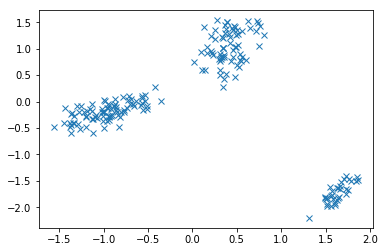

In [369]:
data = scale(data)
plot(data.T[0],data.T[1],"x")
x_mean = np.mean(data.T[0])
y_mean = np.mean(data.T[1])

In [375]:
def likelihood(X,c,mus,sigs):
    l = 0
    #print(mus)
    for k in range(len(X)):
        tmp = 0
        for i in range(c):
            #print("gaussian:",gaussian(X[k],mus[i],sigs[i]))
            tmp += gaussian(X[k],mus[i],sigs[i])
        #print(np.log(tmp))
        l += np.log(tmp)
    #print("l:",l)
    #print(mus)
    #print(sigs)
    return l

In [376]:
def gaussian(x,mean,cov):
    """多変量ガウス関数"""
    x = np.array(x)
    mean = np.array(mean)
    cov = np.array(cov)
    temp1 = 1 / ((2 * np.pi) ** (x.size/2.0))
    temp2 = 1 / (np.linalg.det(cov) ** 0.5)
    temp3 = - 0.5 * np.dot(np.dot(x - mean, np.linalg.inv(cov)), x - mean)
    return temp1 * temp2 * np.exp(temp3)

# Step 1

## 初期値を与える

# Step 2

## 各$x_k$に対して$P(w_i|x_k;\theta)$を計算する

## $P(w_i|x_k;\theta) = \frac{\pi_i p(x_k|\omega_i;\theta_i)}{\sum_{j+1}^c \pi_{j}p(x_k|\omega_j;\theta_j)}$

$\pi_i = p(\omega_i)$ : 事前分布。全体においてクラス$\omega_i$に属するサンプルが占める割合。

$p(x_k|\omega_i;\theta_i)$ : クラス$\omega_i$が与えられた時に$x_k$が出力される確率。ここでは$\theta_i$をパラメータに持つ正規分布が$x_k$を出力する確率で、定義より計算できる。

# Step 3

## $\pi_i,\mu_i,\Sigma_i$を更新する

$\hat{\pi}_i = \frac{1}{n}\sum_{k=1}^n P(\omega_i|x_k;\theta)$ : $x_k$が$\omega_i$に属する確率のサンプル平均

$\hat{\mu}_i = \frac{\sum_{k=1}^n P(\omega_i|x_k;\theta) x_k}{\sum_{k=1}^n P(\omega_i|x_k;\theta)}$ : 各サンプルの重み付き平均

$\hat{\Sigma}_i = \frac{\sum_{k=1}^n P(\omega_i|x_k;\theta)(x_k - \hat{\mu}_i)(x_k - \hat{\mu}_i)^t}{\sum_{k=1}^n P(\omega_i|x_k;\theta)}$ : 各サンプルと平均の分散共分散行列の重み付き平均

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
likelihood: -326.20367284691997


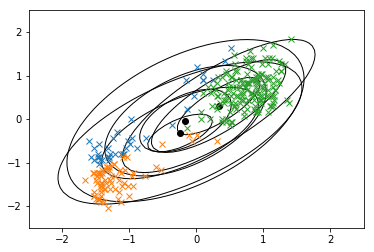

likelihood: -243.79703714243252


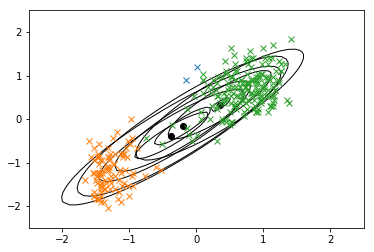

likelihood: -240.27163429374966


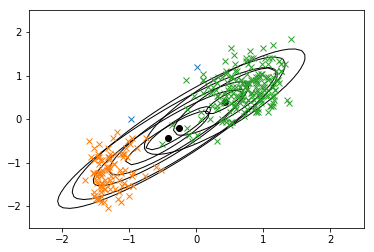

likelihood: -231.79519259500452


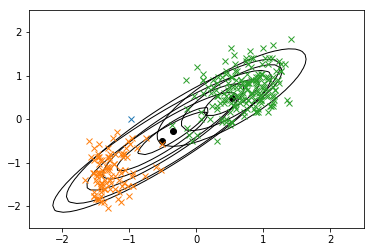

likelihood: -209.12780635484106


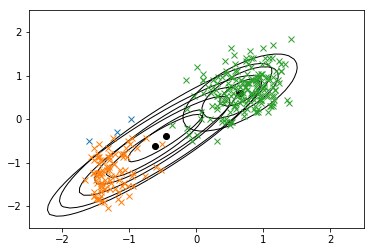

likelihood: -178.0076180535541


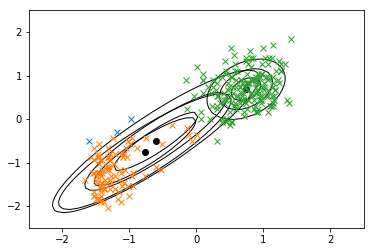

likelihood: -169.98317141735228


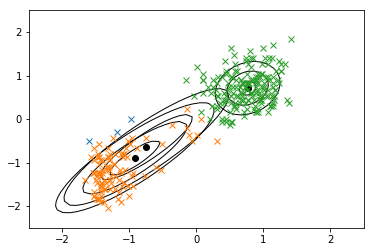

likelihood: -166.96895684443106


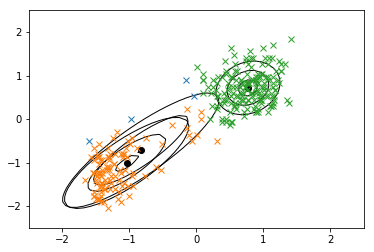

likelihood: -159.1350016886582


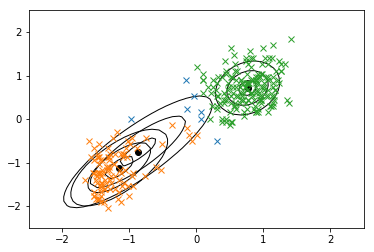

likelihood: -143.20910508237841


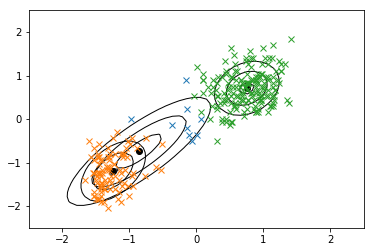

likelihood: -127.84691788472804


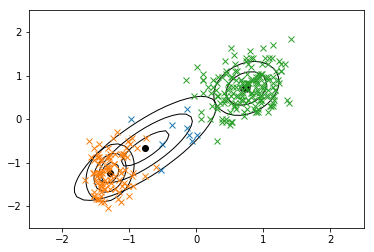

likelihood: -121.75585716305143


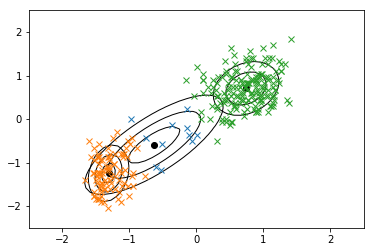

likelihood: -120.94319827990307


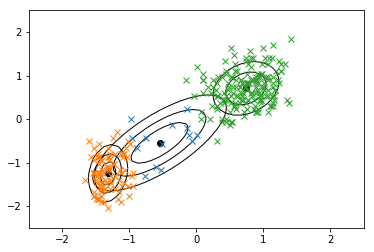

likelihood: -121.66300313347112


In [377]:
# Step 1
# クラス数2
c = 3
# 初期値
mus = []
sigs = []
pis = []
for i in range(c):
    pis.append(1/c)
    m = np.random.normal((x_mean,y_mean))
    s = np.array([[1,0],[0,1]])
    mus.append(m)
    sigs.append(s)
print(pis)
l = likelihood(data,c,mus,sigs)
labels = None
while True:
    Prob = np.zeros((len(data),c))
    
    # Step 2
    ## E-step
    for k in range(len(data)):
        # 分母を計算
        constant = 0
        for j in range(c):
            constant += pis[j] * gaussian(data[k],mus[j],sigs[j])
        #print(constant)
        for i in range(c):
            Prob[k][i] = pis[i] * gaussian(data[k],mus[i],sigs[i]) / constant

    # Step 3
    ## M-step
    new_pis = []
    new_mus = []
    new_sigs = []
    for i in range(c):
        new_pi = np.sum([p[i] for p in Prob]) / n
        constant = sum([Prob[k][i] for k in range(n)])
        #print([np.array(data[k])*Prob[k][i] for k in range(n)])
        new_mu = np.zeros((dim))
        for k in range(n):
            new_mu += np.array(data[k])*Prob[k][i]
        new_mu /= constant
        #print(new_mu)
        new_sig = np.zeros((dim,dim))
        for k in range(n):
            tmp = np.array(data[k]) - np.array(mus[i])
            new_sig += Prob[k][i] * np.outer(tmp,tmp)
        new_sig /= constant
        new_pis.append(new_pi)
        new_mus.append(new_mu)
        new_sigs.append(new_sig)
    new_likelihood = likelihood(data,c,new_mus,new_sigs)
    #print(mus)
    
    # 対数尤度が増加していれば継続
    print("likelihood:",new_likelihood)
    if new_likelihood - l < 0.00001:
        break
    pis = new_pis
    mus = new_mus
    sigs = new_sigs
    l = new_likelihood
    
    # クラスタリング
    new_labels = []
    for i in range(c):
        new_labels.append([])
    for k in range(n):
        index = np.argmax(Prob[k])
        new_labels[index].append(k)
    labels = new_labels
    # plot
    clf()
    xlist = np.linspace(-2.5, 2.5, 50)
    ylist = np.linspace(-2.5, 2.5, 50)
    x, y = np.meshgrid(xlist, ylist)
    for i in range(c):
        z = bivariate_normal(x, y, np.sqrt(sigs[i][0][0]), np.sqrt(sigs[i][1][1]), mus[i][0], mus[i][1], sigs[i][0][1])
        cs = contour(x, y, z, 3, colors='k', linewidths=1)
        #cs = contour(x, y, z, 3, linewidths=1)
        plot(mus[i][0],mus[i][1],'ko')
        plot(data[labels[i]].T[0],data[labels[i]].T[1],"x")
    show()

# 参考文献

- 石井・上田　続・わかりやすいパターン認識（オーム社）